# Lab 2: Classification (Part 1)

## Name: Shamith Achanta (shamith2)

### Due September 9, 2020 11:59 PM

#### Logistics and Lab Submission

See the [course website](https://courses.engr.illinois.edu/ece365/fa2019/logisticsvvv.html).

#### What You Will Need To Know For This Lab

This lab covers some basic classifiers which can be used for M-ary classification.

- Bayes Classifiers
- Linear Discriminant Analysis
- k-Nearest Neighbors

There are some problems which have short answer questions. <b>Do not write an essay -- a few (1-2) complete sentences will suffice.</b>

<b>Also, be clear about your answers</b>. For example, if a question asks you "Which classifier would you choose?", be unequivocal about which classifier you would choose (and why); as engineers, part of your job is to make design decisions and justify them in comparison to the alternatives. 

#### Preamble (Don't change this)

In [1]:
%pylab inline
import numpy as np
import scipy.spatial.distance as dist
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data needed for Problems 1-3 

# Read the data
traindata_tmp= genfromtxt('train.csv', delimiter=',')
valdata_tmp= genfromtxt('val.csv', delimiter=',')

#The data which you will use to train LDA and kNN is called "trainingdata"
trainingdata=traindata_tmp[:,:2]
#The corresponding labels are in "traininglabels"
traininglabels=traindata_tmp[:,2]

#The data which you will use to validate LDA, kNN and the Bayes Classifier
#is called "valdata"
valdata=valdata_tmp[:,:2]
#The corresponding labels are in "vallabels"
vallabels=valdata_tmp[:,2]

In [3]:
# Some code to visualize decision regions in Problem 1 to 3; you don't need to look at this
adp=np.vstack([trainingdata,valdata])
xmin,xmax = adp[:,0].min()-1, adp[:,0].max()+1
ymin,ymax = adp[:,0].min()-1, adp[:,0].max()+1
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.05),np.arange(ymin, ymax, 0.05))
drdata= np.c_[xx.ravel(), yy.ravel()]

#### Problem 1 : Bayes Classifiers (20 points + 5 bonus points)

In this section, you will implement a Bayes classifier for the following $M$-ary classification problem:

$$H_y: \mathbf{X} \sim \mathcal{N}(\mathbf{\mu}_y,{\sf C}) \qquad y=0,\ldots,M-1$$

i.e. the data is a $d$-dimensional Gaussian with a common covariance matrix $\sf C$ among all classes, but the means are different (and there is a prior among the classes). Remember, when the mean vectors, covariance matrix and prior probabilities are known, no classifier can do better than the Bayes classifier.

You will write a function which takes in 4 parameters:
* A set of data to classify (with rows as feature vectors) as a $(V,d)$ numpy.ndarray (data)
* A M-length vector with the prior probabilities of each class as a numpy.ndarray (pi)
* A matrix with rows giving the class means as a $(M,d)$ numpy.ndarray (means)
* The common covariance matrix as a $(d,d)$ numpy.ndarray (cov)

It will output a length $V$ numpy.ndarray of the outputs of the classifier (labels). You may not use scikit-learn or similar to implement this. Note that the class labels in this problem are $0,1,2$ (not $1,2,3$). Since Python uses zero-based indexing, this will allow you to avoid a few +1's in your code. 

<b>Note that there are 5 bonus points for not using loops in Problem 1.</b>

Some hints
* If you did lab 1, exercises 5 and 6, they will get you through the bulk of this problem.
* A non-exhaustive list of useful functions: numpy.linalg.inv, numpy.sum, numpy.log, numpy.argmax.
* You may use <a href="http://docs.scipy.org/doc/numpy-1.10.1/user/basics.broadcasting.html">broadcasting</a> to help simplify your code. The basic form you may want to use is, if you have code which says A + B where A is (n,m) and B is (m,) then numpy will automatically translate this to adding B to each row of A. 


A function prototype is provided below <b>(10 points)</b>:

In [4]:
def bayesClassifier(data,pi,means,cov):
    # Put your code here
    # number of samples in data and dimensions of feature vector
    n, d = data.shape
    # number of labels in data
    l = means.shape[0]
    # predictions
    pred = np.zeros(n)
    
    # x = data - mean (with distinct labels)
    x = np.subtract(data, np.split(means, l))
    
    # c = inv(cov)
    c = np.linalg.inv(cov)
    
    # nc := normalizing constant
    nc = -0.25 * np.log(np.power(2*np.pi, d) * np.linalg.det(cov))
    
    # p := p(class|data)
    # p(class|data) = pi * p(data|class)
    # log(p(class|data)) = log(pi) + log(p(data|class))
    # log(p(class|data)) = np.log(pi) + nc - (0.5 * (x.T * c * x))
    p = np.add(np.log(pi).reshape((l,1)), (nc - 0.5 * (np.dot(x, c) * x).sum(axis=2))).T  # dim = (n, l)
     
    # argmax p(class|data) = argmax log(p(class|data))
    pred = np.argmax(p, axis=1)
    
    return pred

Now, you will write a function which calculates the error of a classifier using the $0,1$-loss by comparing the true labels and the predicted labels. 

The function will take in two parameters:
* A vector of length $N$ with the true labels as a numpy.ndarray (truelabels)
* A vector of length $N$ with the estimated labels as a numpy.ndarray (estimatedlabels)

The function will return the error (a scalar).

A function prototype is provided below <b>(5 points)</b>:

In [5]:
def classifierError(truelabels,estimatedlabels):
    # Put your code here
    # 0-1 loss err = # of misclassified labels / total number of labels
    # number of misclassified labels
    misclassified = sum(truelabels != estimatedlabels)
    
    # classifier loss
    return misclassified / len(truelabels)

Now, we will load some sample data, in the format specified above. 
We have three classes, with
$$\pi_0=\frac{1}{4}, \pi_1=\frac{1}{4}, \pi_2=\frac{1}{2}$$

$$\mathbf{\mu}_0=\begin{bmatrix} 1 \\ 5\end{bmatrix},\mathbf{\mu}_1=\begin{bmatrix} 5 \\ 0\end{bmatrix}, \mathbf{\mu}_2=\begin{bmatrix} -2\\-2\end{bmatrix} $$

$$\Sigma=\begin{bmatrix} 5 & 1 \\ 1 & 5 \end{bmatrix}$$


In [6]:
# The prior information
pi=np.array([1/4,1/4,1/2])
means=np.array([[1,5],[5,0],[-2,-2]])
cov=np.array([[5,1],[1,5]])
# The data which you will use to test the classifier is called "data"
data=np.copy(valdata)
# The labels are in "truelabels"
truelabels=np.copy(vallabels)

Let's visualize the data by class. Each class will be in a different color.

(-7.345781630824372, 11.62528163082437, -8.5409666004415, 12.0151666004415)

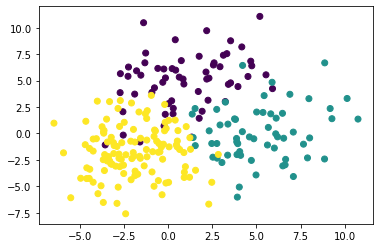

In [7]:
scatter(data[:,0], data[:,1], c=truelabels)
axis('tight')

Run the classifier on the data in `data` with labels `truelabels`. Store the predicted labels in a variable called `estimatedlabels` and report the classifier's error rate. Also, run the classifier on the data in `drdata` and store the labels outputted by the classifier into a variable called `drB`. We will use `drB` to help visualize the decision regions. <b>(5 points)</b>

In [8]:
# Put your code here.
estimatedlabels = bayesClassifier(data,pi,means,cov)
error = classifierError(truelabels,estimatedlabels)

print("\nValidation (Classification) Error: {}\n".format(error))

drB = bayesClassifier(drdata, pi, means, cov)


Validation (Classification) Error: 0.09583333333333334



**[Classification Error: 0.09583 or 9.583 %]**

Now, lets visualize the output of our classifier. 

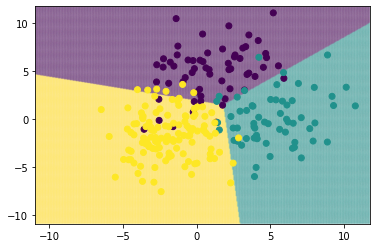

In [9]:
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(data[:,0],data[:,1],c=truelabels)

You should observe linear boundaries between the decision regions and almost all the points are in the correct region for this problem. 

#### Problem 2 : Linear Discriminant Analysis (25 points)

In this problem, you will implement Linear Discriminant Analysis (LDA). You will use the Bayes classifier from Problem 1 to do this. You will be given:
* Training data feature vectors as a $(N,d)$ numpy.ndarray (trainfeat), where each row is a feature vector.
* Training data labels as a length $N$ numpy.ndarray (trainlabel)

The first function you will write will return a tuple of the estimates of the prior probabilities (as a $M$ length numpy.ndarray), means (as a $(M,d)$ numpy.ndarray) and covariance matrix (as a $(d,d)$ numpy.ndarray) in the LDA model. You may assume that labels $0,\ldots,$trainlabel.max() exist in order to avoid some error checking. 

A hint:
* You can use logical operations+slicing to index an array. For example, if you want to get all training feature vectors whose  labels are `i`, you can use `trainfeat[trainlabel==i]`

A function prototype is provided below: <b>(10 points)</b>

In [10]:
def trainLDA(trainfeat,trainlabel):
    nlabels=int(trainlabel.max())+1 #Assuming all labels up to nlabels exist.
    pi=np.zeros(nlabels) # store your prior in here
    n, d = trainfeat.shape # total number of samples and dimensions
    means=np.zeros((nlabels,d)) # store the class means in here
    cov=np.zeros((d,d)) # store the covariance matrix in here
    
    # Put your code here    
    for i in range(nlabels):
        # I(yi == i) * xi
        train_i = trainfeat[trainlabel == i]
        
        # conpute priors
        pi[i] = len(trainlabel[trainlabel == i]) / n 

        # compute means
        means[i] = np.mean(train_i, axis=0)
        
        # compute covariance matrix
        # x = data - means (with distinct labels)
        x = np.concatenate(np.subtract(np.split(train_i, train_i.shape[0]), means[i]))
        cov = np.add(cov, np.dot(x.T, x))
    
    # normalize covariance matrix
    cov = cov / n

    return (pi,means,cov)

Our training data is in a numpy array called `trainingdata`, with corresponding labels `traininglabels`. Our validation data is in a numpy array called `valdata`, with corresponding labels `vallabels`. The data format is the same as Problem 1. 

And we can visualize the training data:

(-10.925541630824373, 10.317241630824372, -9.638406600441503, 11.7238066004415)

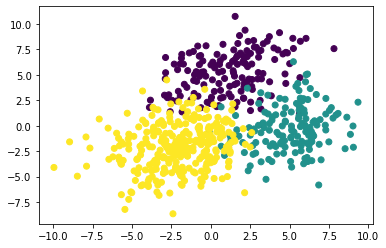

In [11]:
# We will use the following code to visualize the decision regions of the classifier.
# You don't need to look at this cell.

scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
axis('tight')

Use the bayesClassifier function you wrote in Problem 1 along with the trainLDA function from Problem 2 to implement the LDA classifier. Train the LDA classifier on the training data in `trainingdata`, and then run the LDA classifier on the training data and the validation data. Store the predicted training labels in `estimatedtraininglabels` and the predicted labels on the validation data in `estimatedvallabels`. Print out the prior, means and covariance estimated in LDA. (And don't forget to run your LDA classifier on the data in `drdata` and store the resultant predicted labels in `drLDA` to help visualize the output of the classifier.) <b>(5 points)</b>

In [12]:
# Put your code here
# training LDA classifier
pi, means, cov = trainLDA(trainingdata, traininglabels)

print("prior: \n {} \n\nmeans: \n {} \n\ncovariance: \n {}".format(pi, means, cov))

# classifing training data
estimatedtraininglabels = bayesClassifier(trainingdata, pi, means, cov)
# validating LDA classifier
estimatedvallabels = bayesClassifier(valdata, pi, means, cov)

# drLDA
drLDA = bayesClassifier(drdata, pi, means, cov)

prior: 
 [0.25 0.25 0.5 ] 

means: 
 [[ 1.12191279  5.17315581]
 [ 4.91358665 -0.28614234]
 [-2.07276858 -2.11161245]] 

covariance: 
 [[4.65175173 1.03950119]
 [1.03950119 4.76683419]]


The training data is generated with the distribution used in Problem 1, so your $\pi, \mu, {\sf C}$ should all be pretty close to the ones given in Problem 1. If they are not close, you've done something wrong. 

Now, calculate the errors. Report the training error (error of the classifier on the training data) and the validation error (error of the classifier on the validation data). <b>(5 points)</b>

In [13]:
# Put your code here
train_error = classifierError(traininglabels, estimatedtraininglabels)
val_error = classifierError(vallabels, estimatedvallabels)
print("Training Error: {}".format(train_error))
print("Validation Error: {}".format(val_error))

Training Error: 0.07333333333333333
Validation Error: 0.10833333333333334


**[Training Error = 0.07333 or 7.333 % and Validation Error = 0.10833 or 10.833 %]**

We can also visualize the performance of the classifier on the training and validation data. In this problem, both the training and validation data was generated from the distributions specified in Problem 1, so we show both the LDA classifier (which you learned from the data) and the Bayes classifier (which assumed you knew the true joint distribution of the data and the labels). 

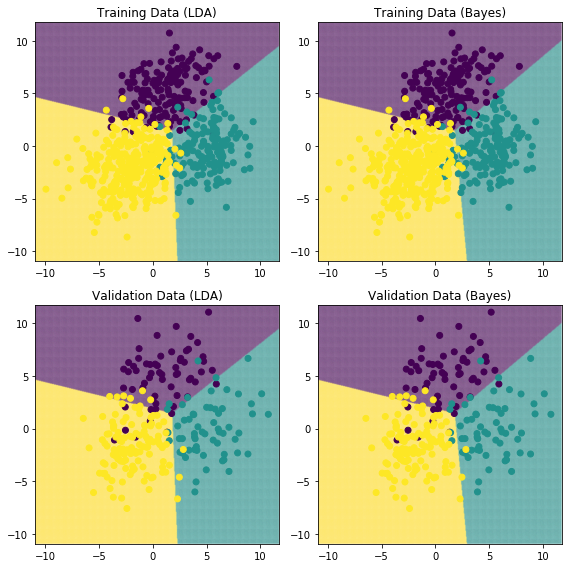

In [14]:
figure(figsize=(8, 8)) # If this is looking a bit squished, you can change the 8 (width) and 8 (height)
subplot(2,2,1)
pcolormesh(xx,yy,drLDA.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
title('Training Data (LDA)')
subplot(2,2,2)
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
title('Training Data (Bayes)')
subplot(2,2,3)
pcolormesh(xx,yy,drLDA.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(valdata[:,0],valdata[:,1],c=vallabels)
title('Validation Data (LDA)')
subplot(2,2,4)
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(valdata[:,0],valdata[:,1],c=vallabels)
title('Validation Data (Bayes)')
tight_layout()

Most of the points should be correctly classified in both the training and validation data. If they are not, you've done something wrong. 

In this problem, we see that the LDA classifier gives boundaries which are quite similar to the Bayes classifier (assuming you've implemented both correctly). If you had a lot of training data from an <b>arbitrary distribution</b>, would you expect the LDA classifier to give similar boundaries to the Bayes classifier? Why or Why not? <b>(5 points)</b>

**[When data (probability density functions) is normally distributed, LDA converges to an optimal solution, that minimizes the generalization error. When data is arbitrary and non-gaussian, the solution may not be optimal, and hence, LDA classifier might not give similar boundaries as the Bayes classifier.]**

#### Problem 3: k-Nearest Neighbors + Some Short Answer Questions (35 points)

In this problem, you will implement the k-Nearest Neighbors algorithm.

The following imports are copied from the beginning for your benefit.

In [15]:
import scipy.spatial.distance as dist
from scipy import stats

Your function will take:
* Training data feature vectors as a $(N,d)$ numpy.ndarray (trainfeat), where each row is a feature vector
* Training data labels as a length $N$ numpy.ndarray (trainlabel)
* Test data feature vectors as a $(V,d)$ numpy.ndarray (testfeat), where each row is a feature vector
* The value of k

Use the Euclidean distance (scipy.spatial.distance.cdist) as your dissimilarity measure. Read the documentation!

Your function should return a length $V$ numpy.ndarray vector of the estimated labels. This should take around 4 lines of code. Do not use the kNN implementation in scikit-learn or similar.

Some functions which may be useful (read the documentation!):
* The numpy.argpartition function can be used to find the $k$ smallest elements of an array (via slicing)
* scipy.stats.mode can find the most common element in an array. Check the output.

<b>(10 points)</b>

In [16]:
def kNN(trainfeat,trainlabel,testfeat,k):
    #Put your code here
    # euclidean distances between all training and test points
    distances = dist.cdist(testfeat, trainfeat, 'euclidean')
    # indices of k nearest neighbours
    idx = np.argpartition(distances, k)
    # k nearest neighbours labels
    nn = np.take_along_axis(np.broadcast_to(trainlabel, distances.shape), idx, axis=-1)[:, :k].T
    
    # return the most frequent label
    return stats.mode(nn)[0]

Run your k-Nearest Neighbors classifier with the training data in `trainingdata` and validation data in `valdata` from Problem 2, for $k=1,3,4,5$. Compute the training and validation error rates on the data from Problem 2. <b>(5 points)</b>

In [17]:
# Put your code here
for k in [1, 3, 4, 5]:
    estimatedtraininglabels = kNN(trainingdata, traininglabels, trainingdata, k)
    estimatedvallabels = kNN(trainingdata, traininglabels, valdata, k)
    train_error = classifierError(traininglabels, estimatedtraininglabels)
    val_error = classifierError(vallabels, estimatedvallabels)
    print("k= {}: \n Training Error: {}".format(k, train_error))
    print(" Validation Error: {}\n".format(val_error))

k= 1: 
 Training Error: 0.0
 Validation Error: 0.1125

k= 3: 
 Training Error: 0.056666666666666664
 Validation Error: 0.10833333333333334

k= 4: 
 Training Error: 0.06333333333333334
 Validation Error: 0.10833333333333334

k= 5: 
 Training Error: 0.06
 Validation Error: 0.1



Which value of k would you choose for the k-NN classifier? Why? Run your k-NN classifier with the chosen value of k on  the data in `drdata` and store the result in a variable called `drK`. <b>(5 points)</b>

**[I chose k = 5 because KNN with k = 5 has the least validation error (and low training error as well). Low validation error is makes a model generalize well.]**

In [18]:
k = 5
drK = kNN(trainingdata,traininglabels,drdata,k)

Now, let us visualize the decision boundaries of your chosen value of $k$. 

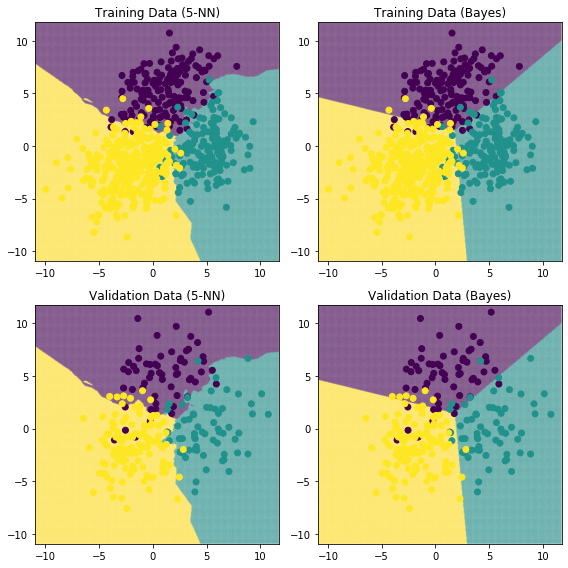

In [19]:
figure(figsize=(8, 8)) # If this is looking a bit squished, you can change the 8 (width) and 8 (height)
subplot(2,2,1)
pcolormesh(xx,yy,drK.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
title('Training Data (%i-NN)'%k)
subplot(2,2,2)
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
title('Training Data (Bayes)')
subplot(2,2,3)
pcolormesh(xx,yy,drK.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(valdata[:,0],valdata[:,1],c=vallabels)
title('Validation Data (%i-NN)'%k)
subplot(2,2,4)
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(valdata[:,0],valdata[:,1],c=vallabels)
title('Validation Data (Bayes)')
tight_layout()

**Some Short Answer Questions**

(1) The training and validation data used in problems 1-3 was all drawn from the distribution described in problem 1.  Compare and contrast the results you got from LDA and k-Nearest Neighbors as well as the Bayes classifier from problem 1. Your answer should consider both computational resources as well as error performance. <b>(5 points)</b>

**[The Bayes classifier was the most accurate of the 3 classifiers, and uses less computational resources than kNN classifier. The 5-NN algorithm is the second most accurate, but uses the most computational resources since it has to find all the nearest neighbours for all the data samples. LDA uses slightly more computational resources than Bayes classifier due to the estimation portion of the training step (but less than kNN classifier), but it is less accurate than kNN classifier for k = 5]**

(2) Compared to other values of k in k-NN, why the training error is zero when you use the standard nearest neighbor (1-NN) algorithm?  <b>(5 points)</b>

**[1-NN algorithm looks for 1 nearest neighbour. It finds patterns in local data clusters (with 1 neighbour) and has high variance. 1-NN tries to fit the training data perfectly. Hence, the training error is zero]**

(3) Assuming you did not have knowledge of the true distribution of the data, out of the classifiers discussed in problems 1-3 (Bayes, LDA, kNN with the k you selected above), which classifier would you prefer in this problem? Why? <b>(5 points)</b>

**[Bayes Classifier finds the optimal solution, with least generalization error, but we need to know the priors. Similarly, LDA classifier assumes data is normally-distributed and hence, may not give the optimal solution for arbitrary and unknown non-gaussian distributions. But, kNN classifier does not assume the distribution of the data and kNN with suitable k (here k = 5) has low generalization error as well. Therefore, I would chose kNN classifier with suitable k, if true distribution of data is unknown]**

#### Problem 4: LDA and kNN using scikit-learn <b>(20 points)</b>

In many cases, you will be using other people's libraries to implement learning algorithms. In this problem, you will become familiar with scikit-learn's implementation of LDA and kNN.

First, we will load a data set of digits drawn from zip codes written on US mail. This data set was designed to help get good algorithms to sort mail by zip code automatically. It has been preprocessed a bit, with details given <a href="http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/zip.info.txt">here</a>. Each feature vector consists of $16^2$ real values representing grayscale values of a 16 by 16 image of a digit. The training data has 7291 samples, while the validation data has 2007 samples. Note that this is not the same dataset built into scikit-learn -- it is much larger. 

In [20]:
#Loading the Data

#Read in the Training Data
traindata_tmp= genfromtxt('zip.train', delimiter=' ') 

#The training labels are stored in "trainlabels", training features in "traindata". Rows are feature vectors.
trainlabels=traindata_tmp[:,0]
traindata=traindata_tmp[:,1:]

#Read in the Validation Data
valdata_tmp= genfromtxt('zip.val', delimiter=' ') 

#The validation labels are stored in "vallabels", validation features in "valdata". Rows are feature vectors.
vallabels=valdata_tmp[:,0]
valdata=valdata_tmp[:,1:]

Use scikit-learn's sklearn.neighbors.KNeighborsClassifier to run a Nearest Neighbor classifier (1-NN) on the validation data with the provided training set. Note that KNeighborsClassifier defaults to 5-NN. 

Measure the time for fitting the model and classification (the %timeit feature or time() or similar will be useful). Try the different algorithms possible to fit the model (ball tree, kd-tree and brute force, and specify the fastest one in your code). Make sure to calculate the error on the validation set.  <b>(5 points)</b>

In [21]:
from sklearn import neighbors
# Insert code here
algorithms = ['ball_tree', 'kd_tree', 'brute']

for algorithm in algorithms:
    neigh = neighbors.KNeighborsClassifier(n_neighbors=1, algorithm=algorithm, metric='euclidean')
    
    print("Algorithm: {}".format(algorithm))
    start_time = time.time()
    neigh.fit(traindata, trainlabels)
    print("Fitting time: {} s".format(time.time() - start_time)) 
    
    start_time = time.time()
    estimatedvallabelsknn = neigh.predict(valdata)
    print("Classifing time: {} s".format(time.time() - start_time)) 
    
    val_error_knn = classifierError(vallabels, estimatedvallabelsknn)
    print("Validation Error: {}\n".format(val_error_knn))

Algorithm: ball_tree
Fitting time: 0.851567268371582 s
Classifing time: 10.784621477127075 s
Validation Error: 0.05630293971101146

Algorithm: kd_tree
Fitting time: 1.4787938594818115 s
Classifing time: 14.427793741226196 s
Validation Error: 0.05630293971101146

Algorithm: brute
Fitting time: 0.012990474700927734 s
Classifing time: 0.6297745704650879 s
Validation Error: 0.05630293971101146



**[Fitting: 0.013 s and Classifying: 0.630 s and Validation Error = 0.05630 or 5.630 %]**

Now, run LDA on the validation data set with scikit-learn's sklearn.discriminant_analysis.LinearDiscriminantAnalysis class. Measure the training time as well as the time used to classify the validation set. Make sure to calculate the error on the validation set.  <b>(5 points)</b>

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Insert code here
clf = LinearDiscriminantAnalysis()

start_time = time.time()
clf.fit(traindata, trainlabels)
print("Fitting: {} s".format(time.time() - start_time))

start_time = time.time()
estimatedvallabelslda = clf.predict(valdata)
print("Classifing: {} s".format(time.time() - start_time))

val_error_lda = classifierError(vallabels, estimatedvallabelslda)
print("\nValidation Error: {}".format(val_error_lda))

Fitting: 0.5874032974243164 s
Classifing: 0.0043065547943115234 s

Validation Error: 0.114598903836572


**[Fitting: 0.587 s and Classifying: 0.004 s and Validation Error = 0.11459 or 11.459 %]**

(1) Based on the performance on the validation set, which algorithm would you pick (for this particular problem)? Your answer should also take into account computational resources required, error on the validation set, and the cost associated with making an error (in real life -- recall the source of the data). <b>(5 points)</b>

**[I would pick the 'brute-force' k-NN algorithm because it has a lower validation error (0.05630 or 5.630 %) and takes an around 0.643 seconds to train & classify (validation step). Comparatively, LDA, takes an around 0.592 seconds to train & classify, but has higher validation error (0.11459 or 11.459 %). Therefore, eventhough, the 'brute-force' k-NN uses slighty costlier in terms of computational resources, it will have a lower 'real world' cost associated with making an error because it has a lower generalization lower (about 50 % lower) and hence, less resources (people, gasoline, time) will be wasted]**

(2) Do you think the 0,1-loss is appropriate error measure in this case? Why or why not? How can you use domain-specific knowledge to help improve performance for this application?

If you are interested in this in more detail on this problem, see O. Matan et al., "Reading Handwritten Digits: A ZIP Code Recognition System", IEEE Computer, Vol 25, Number 7, pp 59-63, 1992 (<a href="http://yann.lecun.com/exdb/publis/pdf/matan-92.pdf">tech report version here</a>). You do not need to look at this to answer the question. <b>(5 points)</b>

**[0-1 loss is an appropriate error measure because the classification, in this case, is binary. The model either sorts the mails correctly or it doesn't. Given the task of sorting mail by zip code by reading handwritten digits, the performance of this application could be improved by easing the process of recollection; potentially by caching common features. For example, by using an 'online' neural network implementation, we could improve the speed and accuracy of classification since the model will have to process smaller batches of data rather than the full dataset.]**

## And this concludes Lab 2! Congratulations!